Simulated Patient 

In [1]:
import pandas as pd
import numpy as np
import os

from textwrap import wrap
from matplotlib import pyplot as plt
from stable_baselines3 import PPO, A2C, DQN
from sklearn.ensemble import RandomForestClassifier

In [2]:
from environment.fogg_behavioural_model import Patient

In [3]:
updated_every_day = 24 
week = 7 * updated_every_day

In [4]:
eight_weeks = week * 8
five_weeks = week * 5

In [5]:
# Basic stable condition
condition = 'stable'
habituation = False
time_preference_update_step = 9999999999999999 #very high e.g. 9999999999 to make it outside of the intervention time...effectively no preference shift

# Other options (not considered in the AIBI project):
# condition = 'habituated'
# habituation=True
# time_preference_update_step= 9999999999999999 

# condition = 'changed_preference'
# habituation=False
# time_preference_update_step= five_weeks

# condition = 'habituated_changed_preference'
# habituation=True
# time_preference_update_step= five_weeks

In [6]:
# 500 runs in the paper
runs = 500

In [7]:
results_directory = 'results'
if not os.path.exists(results_directory):
    os.makedirs(results_directory)

# No interverntion

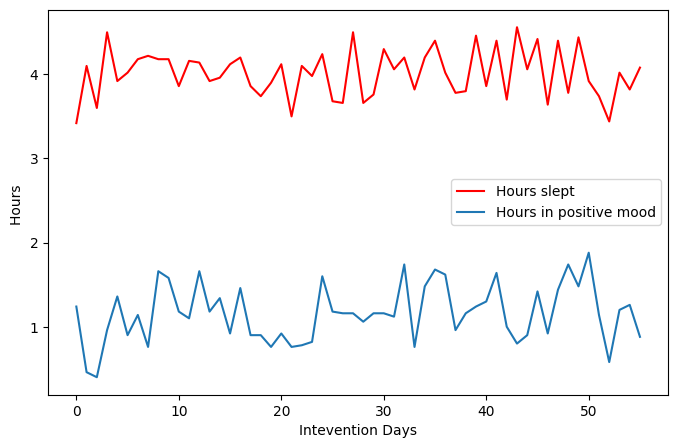

In [8]:
sleep_list = []
positive_list = []

for run in range(0, runs):
    
    # ENTER PATIENT PROFILE FROM 0 TO 3
    env1 = Patient(behaviour_threshold=20, habituation=habituation, time_preference_update_step=time_preference_update_step, patient_profile=0 )
    action = 0
    for i in  range(eight_weeks):
        
        observation, reward, done, _, info = env1.step(action)
        action = 0
    
    
    sleep_list.append(env1.h_slept)
    positive_list.append(env1.h_positive)

fig = plt.figure( figsize=(8, 5))
plt.plot(np.nanmean(sleep_list, axis=0), label='Hours slept', color ='r')
plt.plot(np.mean(positive_list, axis=0), label='Hours in positive mood')
plt.ylabel('Hours ')
plt.xlabel('Intevention Days')
plt.legend()
plt.show()

# Intervention

In [9]:
def intervention(method, runs, name, condition):
    rr_random_list = []
    not_random_list = []
    sleep_list = []
    positive_list = []
    performed = 0
    for run in range(0, runs):
        
        # ENTER PATIENT PROFILE FROM 0 TO 3
        env1 = Patient(behaviour_threshold=20, habituation=habituation, time_preference_update_step=time_preference_update_step, patient_profile=0 )
        env1 = method(env1)
        if sum(env1.num_performed):
            performed += 1
        df = pd.DataFrame()
        df['response_ratio'] = env1.rr
        df['activity performed'] = env1.num_performed
        df['notifications'] = env1.num_notified
        df['sleep'] = env1.h_slept
        df['positive'] = env1.h_positive
        df['non_stationary'] = env1.h_nonstationary
        
        df.to_csv("{0}/patient1_{1}_{2}_run{3}.csv".format(results_directory, condition, name, run))
        rr_random_list.append(df.response_ratio)
        not_random_list.append(df.notifications)
        sleep_list.append(df.sleep)
        positive_list.append(df.positive)

    
    print("This figures include runs in which no prompt resulted in the activity being performed")
    print("{0} out of {1} resulted in activity being performed ".format(performed, runs))
    fig = plt.figure( figsize=(8, 5))
    plt.plot(np.nanmean(np.array(sleep_list), axis=0), label='Hours slept', color ='r')
    plt.plot(np.mean(positive_list, axis=0), label='Hours in positive mood')
    plt.ylabel('Hours ')
    plt.xlabel('Intevention Days')
    plt.legend()
    plt.show()

    fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, sharey=False, figsize=(10, 8))
    ax1.plot(np.nanmean(rr_random_list, axis=0), label='response ratio', color ='r')
    ax2.plot(np.nanmean(not_random_list, axis=0), label='num of notifications')
    ax2.set_xlabel('Intervention days')
    ax2.set_ylabel('No. of notifications')
    ax1.set_ylabel('Response ratio')
    plt.show()
    return sleep_list, positive_list, rr_random_list, not_random_list

## Heuristic

Notify every hour except in night and when the patient is alseep

In [10]:
def always_notify(env1, intervention_legth=eight_weeks):
    
    action = 0
    for i in  range(intervention_legth):
        
        observation, _, _, _, _ = env1.step(action)
        if observation[9] == 3 or observation[3] ==1:
            action = 0
        else:
            action = 1
            
    return env1

This figures include runs in which no prompt resulted in the activity being performed
32 out of 50 resulted in activity being performed 


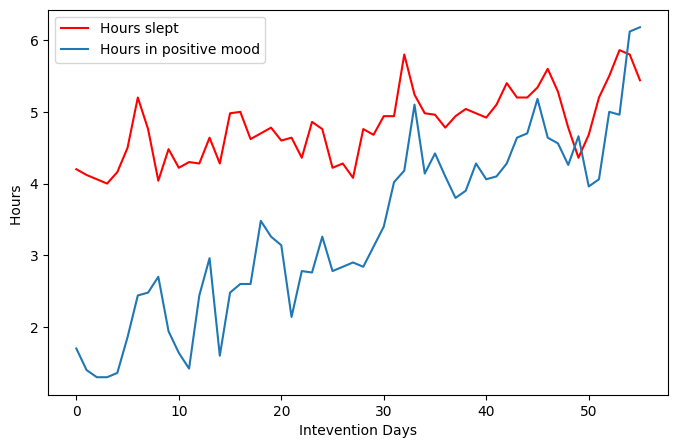

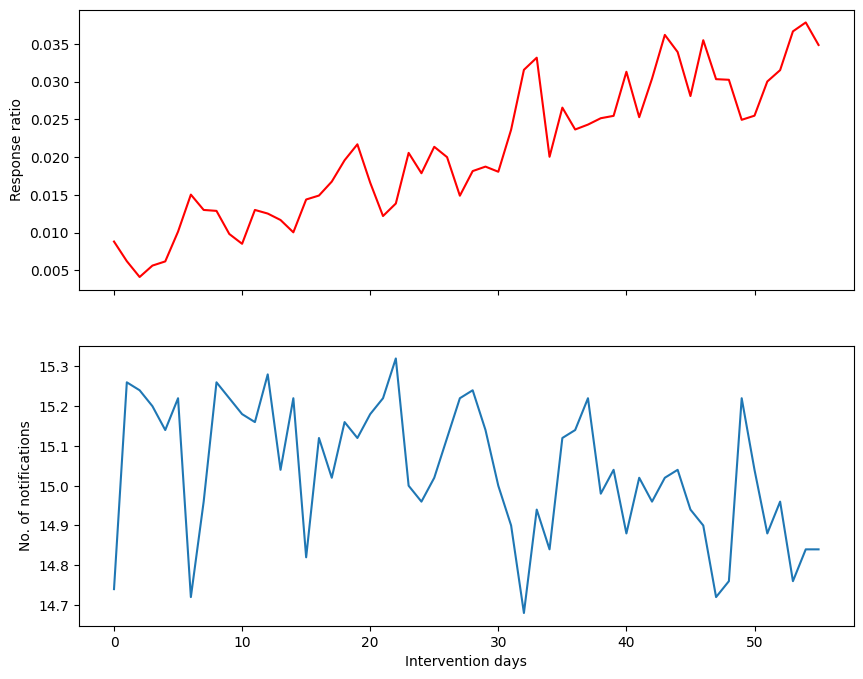

In [11]:
sleep_listh, positive_listh, rr_h_list, not_h_list = intervention(always_notify, runs, 'h', condition)

## Random 
Randomly sample during the day skip the nights

In [12]:
def random_notification(env1, intervention_legth=eight_weeks):
    
    action = 0
    for i in  range(intervention_legth):
        
        observation, _, _, _, _ = env1.step(action)
        if observation[9] ==3:
            action = 0
        else:
            action = env1.action_space.sample()
            
    return env1

This figures include runs in which no prompt resulted in the activity being performed
40 out of 50 resulted in activity being performed 


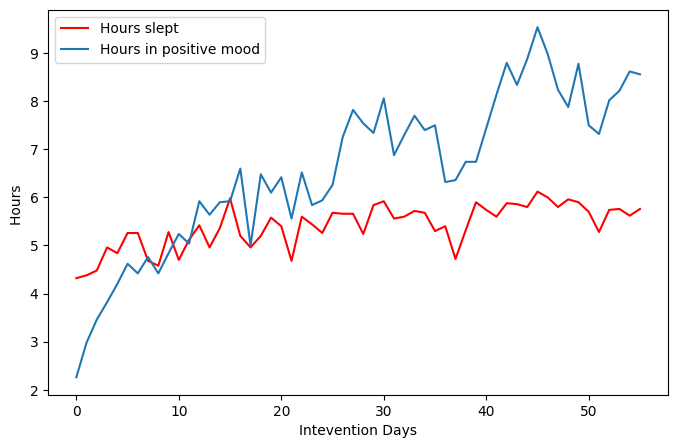

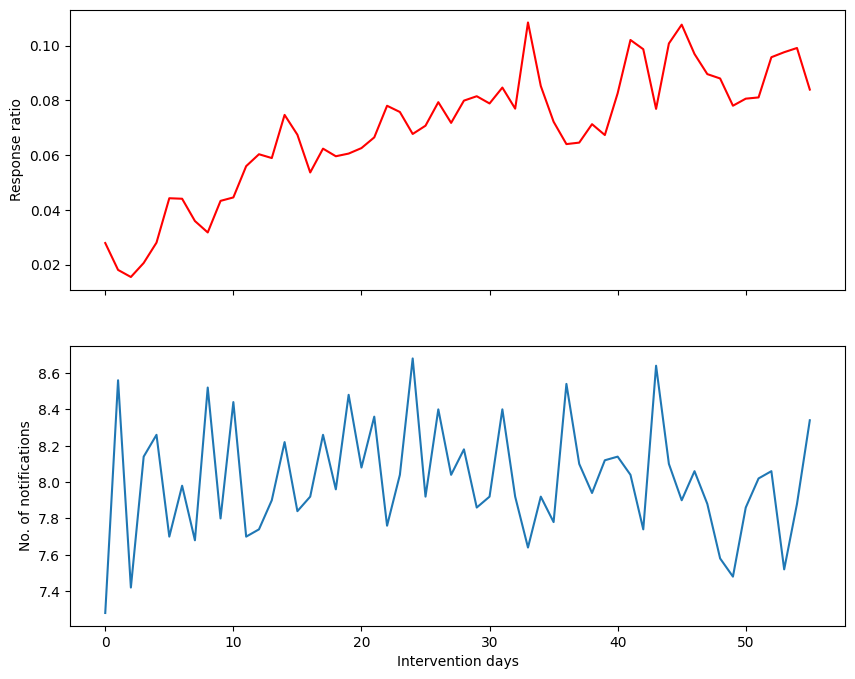

CPU times: total: 2.98 s
Wall time: 3.08 s


In [13]:
%time _ = intervention(random_notification, runs, 'random', condition)

In [14]:
def get_rr_and_notification(name, runs, condition):
    
    rr, noti = [],[]
    failed = 0
    for run in range(runs):
        df = pd.read_csv("{0}/patient1_{1}_{2}_run{3}.csv".format(results_directory,condition, name, run))
        a_performed = sum(df['activity performed'].values)
        if a_performed > 0: # activity performed at least once in the course of the intervention
            rr.append(df.response_ratio)
            noti.append(df.notifications)
        else:
            failed = failed +1 
    print(" {0} out of {1} runs had no activity performed throughout the full intervention.".format(failed, runs))
    return rr, noti, failed

In [15]:
rr_random_list, not_random_list, fppo = get_rr_and_notification('random', runs, condition)

 10 out of 50 runs had no activity performed throughout the full intervention.


## Supervised Learning

### Static model

In [16]:
def supervised_after_three_weeks(env1):
    
    three_weeks = 24 * 7 * 3
    env1 = always_notify(env1, intervention_legth=three_weeks)
    clf = RandomForestClassifier(class_weight='balanced')
    clf.fit(env1.observation_list, env1.activity_performed)
    remaining_time = eight_weeks - three_weeks
    observation = env1._get_current_state()
    for i in range(remaining_time):
        # applying supervised model
        action = clf.predict(np.array([observation]))[0]
        observation, _, _, _, _ = env1.step(action)
        
    return env1

This figures include runs in which no prompt resulted in the activity being performed
23 out of 50 resulted in activity being performed 


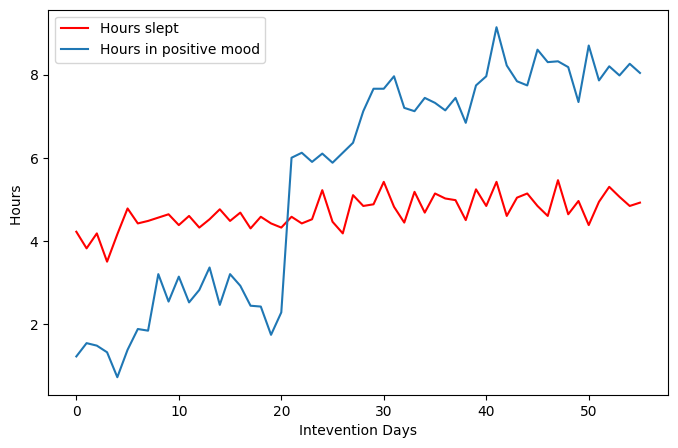

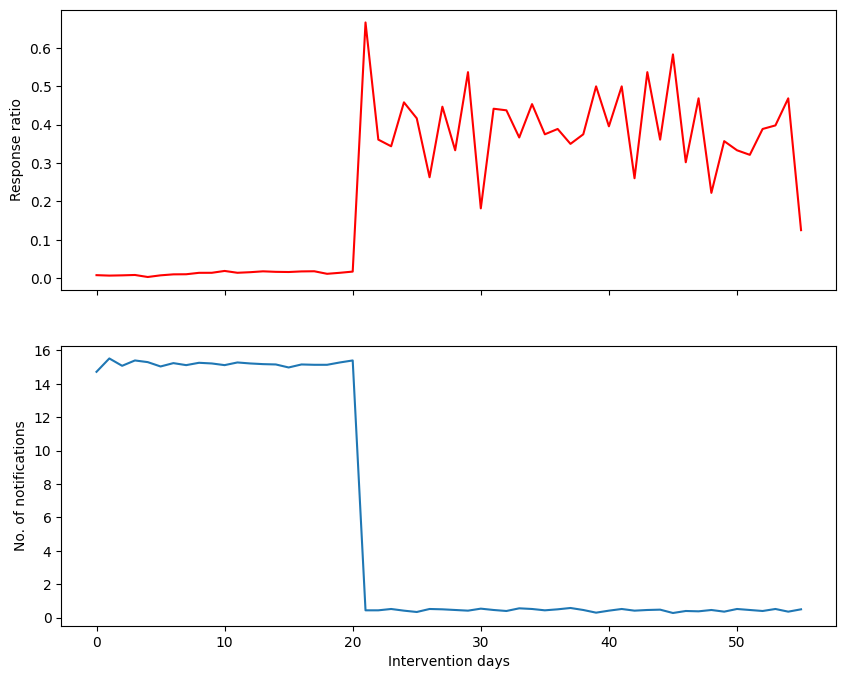

CPU times: total: 5min 51s
Wall time: 5min 55s


In [17]:
%time _ = intervention(supervised_after_three_weeks,runs , 'static_sup3', condition)

### Adaptive model 

In [18]:
def supervised_adaptive_after_three_weeks(env1):
    
    three_weeks = 24*7*3
    env1 = always_notify(env1, intervention_legth=three_weeks)
    clf = RandomForestClassifier(class_weight='balanced')
    clf.fit(env1.observation_list, env1.activity_performed)
    remaining_time = eight_weeks - three_weeks
    observation = env1._get_current_state()
    samples = len(env1.observation_list)
    for i in range(remaining_time):
        # applying supervised model
        action = clf.predict(np.array([observation]))[0]
        observation, _, _, _, _ = env1.step(action)
        if len(env1.observation_list)> samples: # retrain when new samples are provided
            clf = RandomForestClassifier(class_weight='balanced')
            clf.fit(env1.observation_list, env1.activity_performed)
            samples = len(env1.observation_list)
            
        
    return env1

This figures include runs in which no prompt resulted in the activity being performed
20 out of 50 resulted in activity being performed 


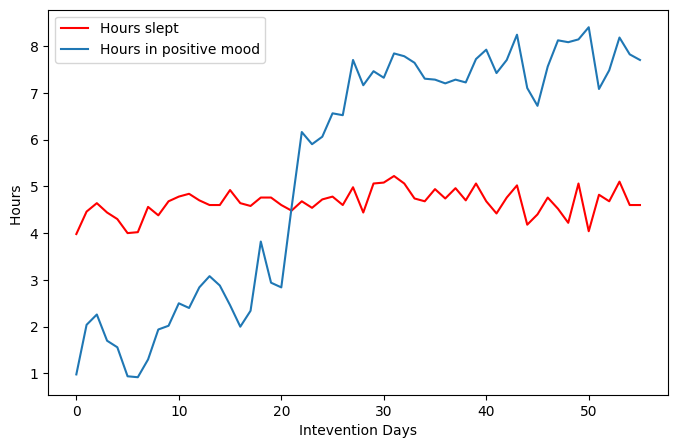

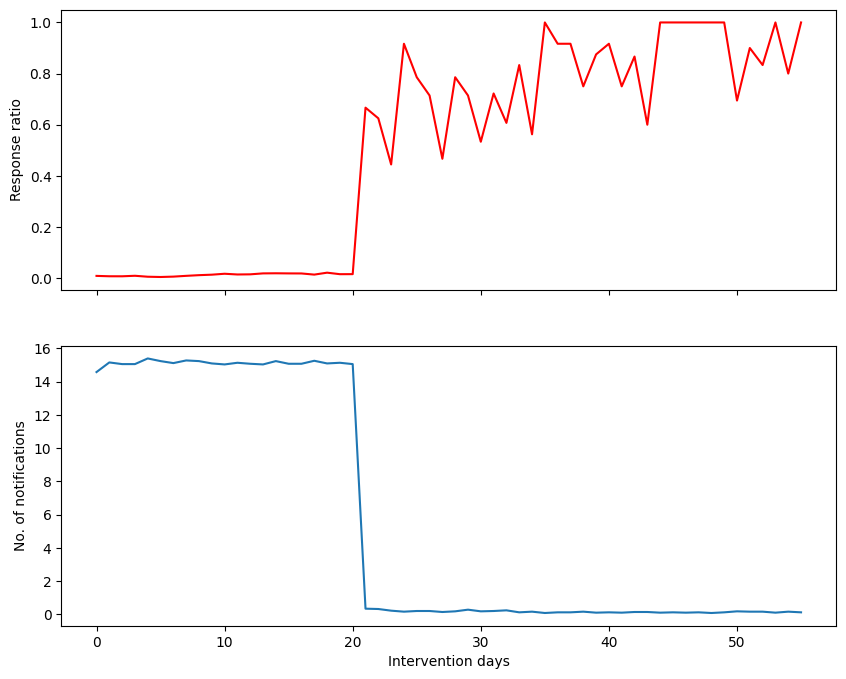

CPU times: total: 6min 9s
Wall time: 6min 13s


In [19]:
%time _ = intervention(supervised_adaptive_after_three_weeks, runs, 'adaptive_sup3', condition)

### How many times supervised training faild?

In [20]:
rr_rf3_list, not_rf3_list, frf3 = get_rr_and_notification('static_sup3', runs, condition)

 27 out of 50 runs had no activity performed throughout the full intervention.


In [21]:
rr_rf3a_list, not_rf3a_list, frf3a = get_rr_and_notification('adaptive_sup3', runs, condition)

 30 out of 50 runs had no activity performed throughout the full intervention.


## Deep Q Network

In [22]:
def dqn(env1):
    model = DQN("MlpPolicy", env1, verbose=0, learning_starts=updated_every_day)
    model.learn(total_timesteps=eight_weeks)
    return env1

This figures include runs in which no prompt resulted in the activity being performed
41 out of 50 resulted in activity being performed 


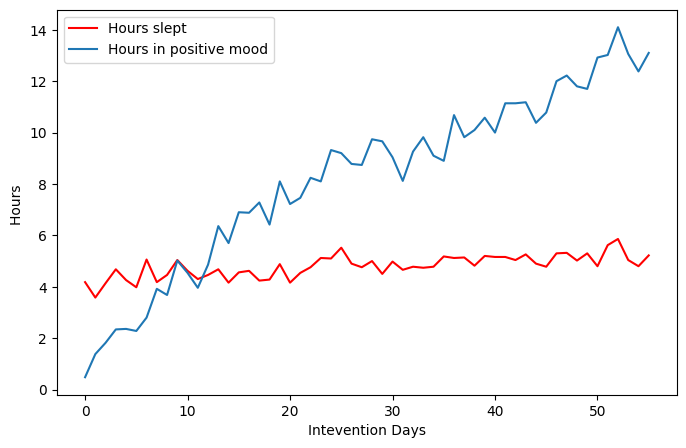

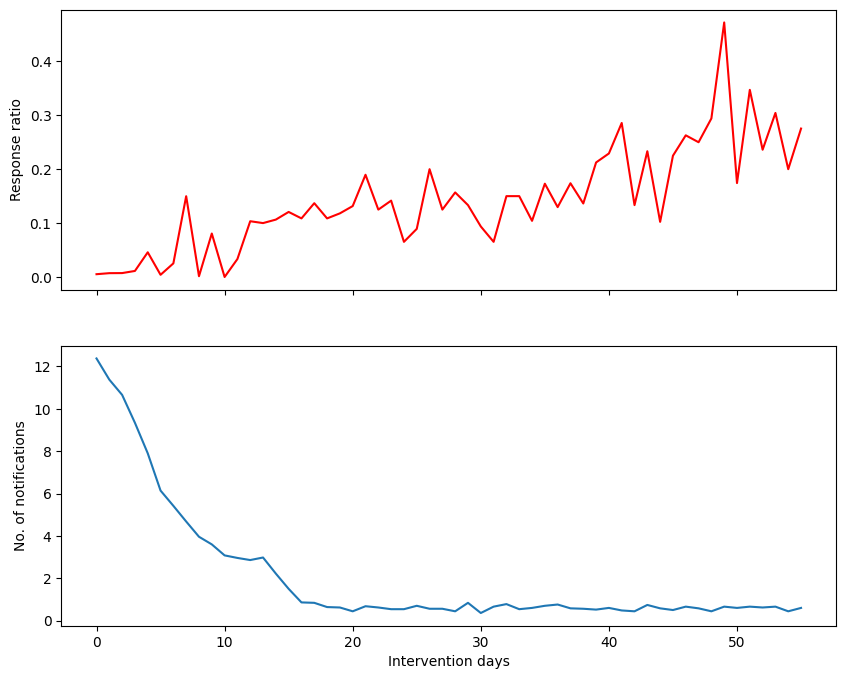

CPU times: total: 4min 4s
Wall time: 4min 21s


In [23]:
%time _= intervention(dqn, runs, 'dqn', condition)

In [24]:
rr_dqn_list, not_dqn_list, fdqn = get_rr_and_notification('dqn', runs, condition)

 9 out of 50 runs had no activity performed throughout the full intervention.


## Proximal Policy Optimisation

In [25]:
def ppo(env1):
    model = PPO("MlpPolicy", env1, verbose=0, n_steps=updated_every_day, batch_size=updated_every_day)
    model.learn(total_timesteps=eight_weeks)
    return env1

This figures include runs in which no prompt resulted in the activity being performed
29 out of 50 resulted in activity being performed 


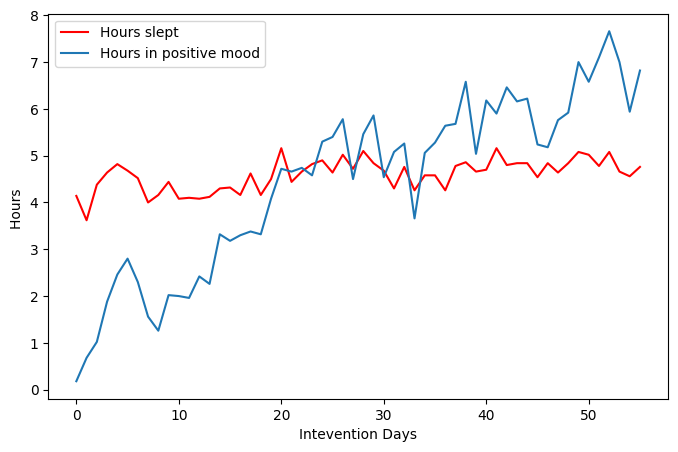

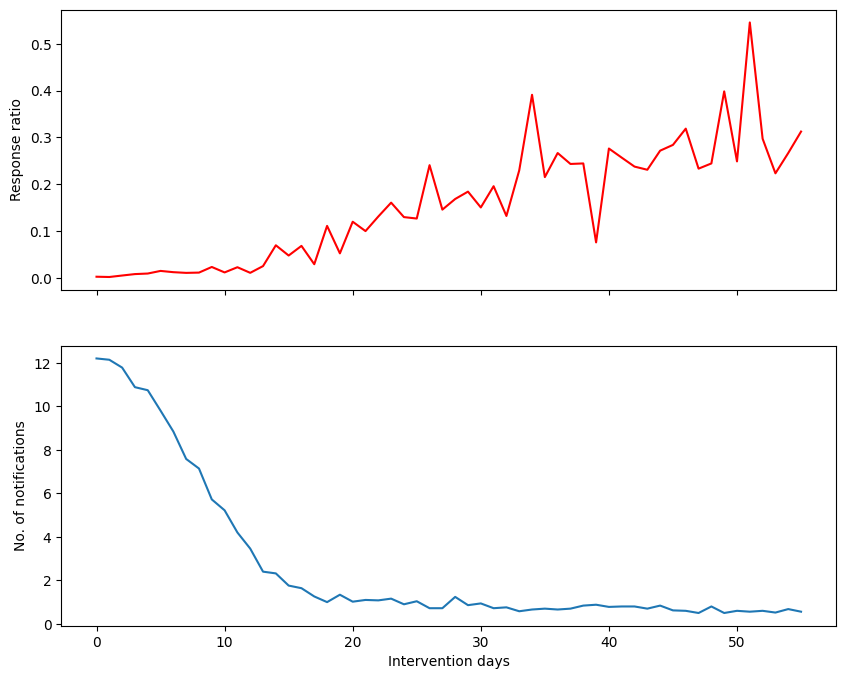

CPU times: total: 9min 50s
Wall time: 9min 52s


In [26]:
%time _= intervention(ppo, runs, 'ppo', condition)

In [27]:
rr_ppo_list, not_ppo_list, fppo = get_rr_and_notification('ppo', runs, condition)

 21 out of 50 runs had no activity performed throughout the full intervention.


## Advantage Actor Critic

In [28]:
def a2c(env1):
    model = A2C("MlpPolicy", env1, verbose=0, n_steps=updated_every_day)
    model.learn(total_timesteps=eight_weeks)
    return env1

This figures include runs in which no prompt resulted in the activity being performed
35 out of 50 resulted in activity being performed 


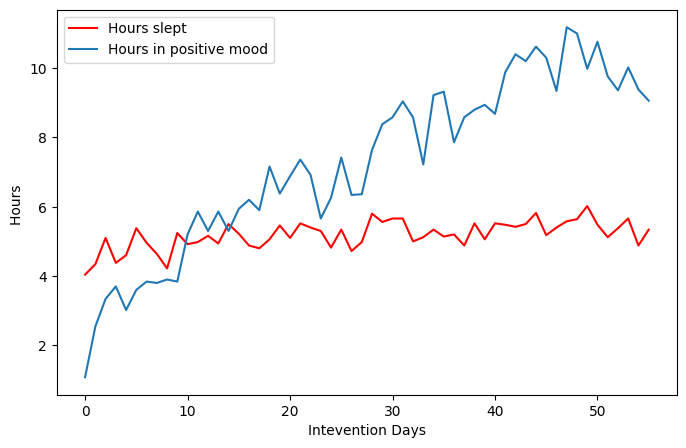

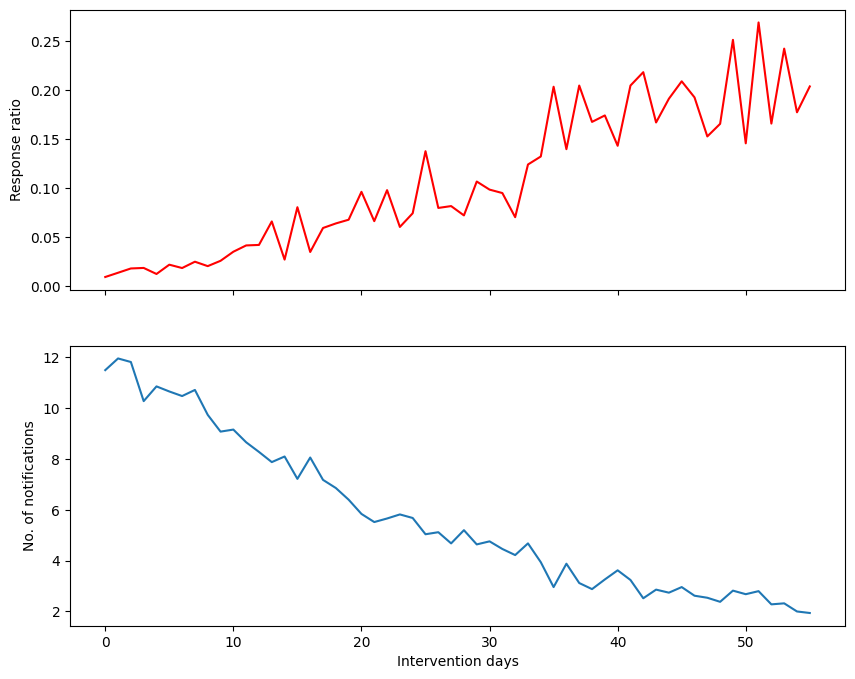

CPU times: total: 5min 31s
Wall time: 4min 54s


In [29]:
%time _ = intervention(a2c, runs, 'a2c', condition)

In [30]:
rr_a2c_list, not_a2c_list, fppo = get_rr_and_notification('a2c', runs, condition)

 15 out of 50 runs had no activity performed throughout the full intervention.


## Comparison between prompt learning stategies

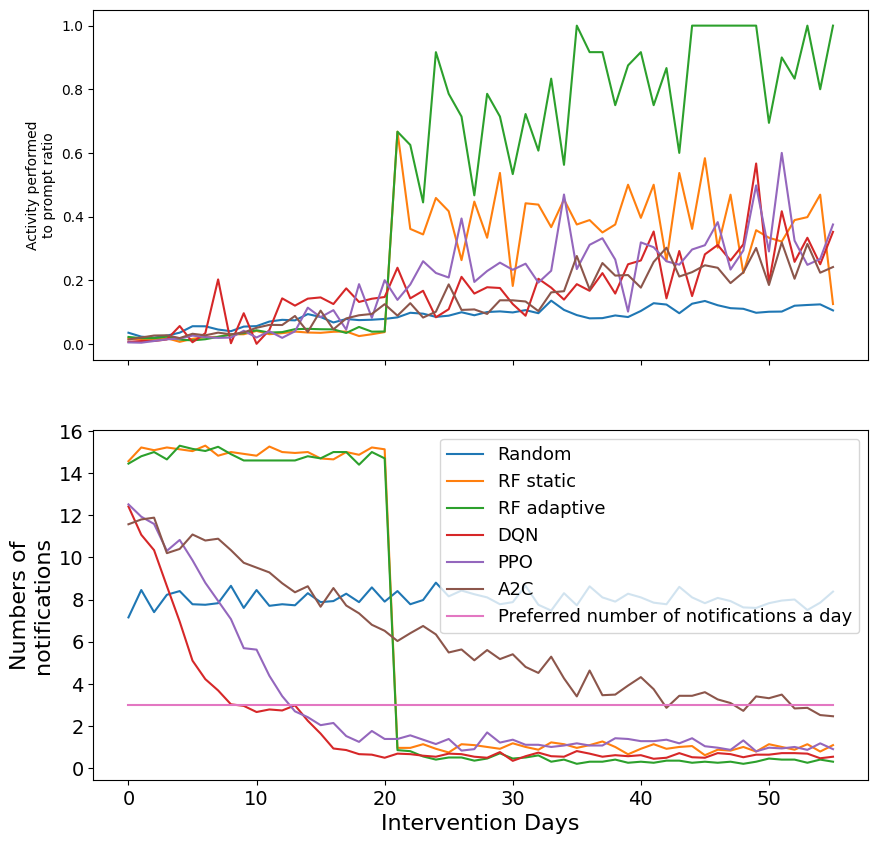

In [31]:
fig, (ax1,ax2) = plt.subplots(2, 1, sharex=True, sharey=False, figsize=(10,10))
ax1.plot(np.nanmean(rr_random_list, axis=0), label='Random')
ax1.plot(np.nanmean(rr_rf3_list, axis=0), label='RF static')
ax1.plot(np.nanmean(rr_rf3a_list, axis=0), label='RF adaptive')
ax1.plot(np.nanmean(rr_dqn_list, axis=0), label='DQN')
ax1.plot(np.nanmean(rr_ppo_list, axis=0), label='PPO')
ax1.plot(np.nanmean(rr_a2c_list, axis=0), label='A2C')


ax2.plot(np.nanmean(not_random_list, axis=0), label='Random')
ax2.plot(np.nanmean(not_rf3_list, axis=0), label='RF static')
ax2.plot(np.nanmean(not_rf3a_list, axis=0), label='RF adaptive')
ax2.plot(np.nanmean(not_dqn_list, axis=0), label='DQN')
ax2.plot(np.nanmean(not_ppo_list, axis=0), label='PPO')
ax2.plot(np.nanmean(not_a2c_list, axis=0), label='A2C')
ax2.plot(np.ones(len(np.mean(not_random_list, axis=0))) +2, label ='Preferred number of notifications a day')

ax2.set_xlabel('Intervention Days', fontsize=16)
ax2.set_ylabel('\n'.join(wrap('Numbers of notifications', 20)), fontsize=16)
ax1.set_ylabel('\n'.join(wrap('Activity performed to prompt ratio', 20)) )
# ax3.set_ylabel( '\n'.join(wrap('Hours slept', 20)) )
# plt.ylim(0, 0.95)
ax2.legend(fontsize=13)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()